<a href="https://colab.research.google.com/github/EGEG1212/TIL/blob/main/1_%EC%98%A4%EB%94%94%EC%98%A4%EC%B2%98%EB%A6%ACAudio_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchaudio

     |████████████████████████████████| 1.9MB 7.9MB/s 


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import librosa #librosa는 각종 음성 처리에 유용한 라이브러리
import librosa.display
import torch
import torchaudio #설치하는데 시간오래걸림;;
import IPython.display as ipd

## 오디오 데이터
- pytorch의 torchaudio를 사용해 내장 데이터셋을 가져옴

In [4]:
#pytorch의 torchaudio를 사용해 내장 데이터셋을 가져오는데 데이터6G가 크기때문에 시간이 55분소요됨
train_dataset = torchaudio.datasets.LIBRISPEECH("./", url="train-clean-100", download=True)
test_dataset = torchaudio.datasets.LIBRISPEECH("./", url="test-clean", download=True)

In [5]:
#불러온 데이터 확인
test_dataset[1]
#pytorch에 있는 텐서 구조를 따라서 오디오데이터가 있음

(tensor([[ 0.0010,  0.0011,  0.0009,  ..., -0.0007, -0.0010, -0.0011]]),
 16000,
 'STUFF IT INTO YOU HIS BELLY COUNSELLED HIM',
 1089,
 134686,
 1)

In [8]:
#불러온 데이터의 형상확인
#데이터 길이만으로는 음성이 몇초에 해당하는디 duration을 알 수 없음
test_dataset[2][0].shape

torch.Size([1, 106000])

## 샘플링 
- 음성을 처리하기 위해, 아날로그정보를 잘개 쪼개>이산적인 디지털정보로 표현해야함    
- 무한히 쪼개어 저장할 수 없으므로, 기준을 세워 아날로그 정보를 쪼개 대표값이용. =샘플링이라한다    
- 주로 시간을 기준으로 아날로그정보를 쪼개는 Time Domain방식을 사용    

- Sampling rate 
  - 잘게 쪼갤수록 정보 손실이 줄어들지만, 데이터의 크기가 늘어남.    
- Sampling theorem  
  - smmpling rate가 최대 frequency보다 2배 커져야 함을 의미기가 늘어남.    
- Sampling theorem  
    - smmpling rate가 최대 frequency보다 2배 커져야 함을 의미
    - 일반적으로 smapling은 인간의 청각 영역에 맞게 형성
        - Audio CD: 44.1kHz(초당 44100 sample) 고품질  
        - Speech communication : 8kHz(초당 8000 sample ) 저품질.목소리 기준 유선전화 대화하는데 문제없는 정도  
  

In [9]:
audio_data = test_dataset[1][0][0]
sr = test_dataset[1][1]

print(audio_data, sr)
print('length:', len(audio_data))
print('duration:', len(audio_data) / sr)

ipd.Audio(audio_data, rate=sr)

tensor([ 0.0010,  0.0011,  0.0009,  ..., -0.0007, -0.0010, -0.0011]) 16000
length: 52400
duration: 3.275


## 리샘플링 Resampling
- sample data의 dampling rate를 조정해 다시 sampling하는것  
- 이때 일반적 보간(interpolation)을할때는 low-pass filter를 사용  
- 메소드 `librosa.resample` 사용하면 편리하게 리샘플가능  
- 현 데이터는 `torch tensor`, `librosa`는 `numpy`배열을 받아들이기 때문에 변환이 필요  
- sampling rate를 절반으로 줄여, 길이도 절반으로 줄은 것을 확인할 수 있음  

In [10]:
audio_np = audio_data.numpy() #넘파이배열로 변환
y_8k = librosa.resample(audio_np, sr, 8000) #16000을 8000으로 줄임

print(len(audio_np), len(y_8k)) #길이가 반으로 줄었다 52400>26200  음질도 전화통화하는듯;
ipd.Audio(y_8k, rate=8000)

52400 26200


In [11]:
#한번 더 4000으로 줄여보자
audio_np = audio_data.numpy() 
y_4k = librosa.resample(audio_np, sr, 4000) 

print(len(audio_np), len(y_4k)) 
ipd.Audio(y_4k, rate=4000)  #초당 4000개의 샘플을 가지고 표현해야하기때문에, 음질이 안좋거나+발음이 안좋거나
#음질이 무전기급;

52400 13100


## Nomalization(정규화) & Quantization(양자화)
데이터간 음량이 제각각인 경우, nomalization을 하여 amplitude(진폭)를 [-1,1]범위로 조정  
여기서는 가장 간단한 방법인 데이터의 최대값으로 나눠주는 방법을 사용  

In [12]:
#정규화되었어도 원본파일과 음질이 같은듯 들린다 ㅋ
audio_np = audio_data.numpy()
normed_wav = audio_np / max(np.abs(audio_np))
ipd.Audio(normed_wav, rate=sr)

In [13]:
#Quantization:음질은 떨어지지만 용량이 줄어듦Quantization:음질은 떨어지지만 용량이 줄어듦; 지지직...노이즈추가됐네;;;...
bit = 8
max_value = 2 ** (bit-1) #2의 7승

quantized_8_wav = normed_wav * max_value
quantized_8_wav = np.round(quantized_8_wav).astype(int)
quantized_8_wav = np.clip(quantized_8_wav, -max_value, max_value-1) # -max_value부터 max_value-1까지
ipd.Audio(quantized_8_wav, rate=sr); 지지직...노이즈추가됐네;;;...
bit = 8
max_value = 2 ** (bit-1) #2의 7승

quantized_8_wav = normed_wav * max_value
quantized_8_wav = np.round(quantized_8_wav).astype(int)
quantized_8_wav = np.clip(quantized_8_wav, -max_value, max_value-1) # -max_value부터 max_value-1까지
ipd.Audio(quantized_8_wav, rate=sr)

## Mu-Law Encoding
- 사람의 귀는 작은소리의 차이는 잘잡아내는데 반해, 소리가 커질수록 그 차이를 잘 느끼지 못함    
- 이러한 특성을 wave값을 표현하는데 반영해 작은 값에는 높은 분별력을,    
큰 값끼리는 낮은 분별력을 갖도록 함    

사람 귀에 적합하도록 만들어준다?  

In [15]:
def mu_law(x, mu=255):
  return np.sign(x) * np.log(1 + mu * np.abs(x)) / np.log(1 + mu)

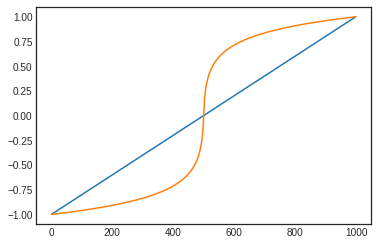

In [16]:
x = np.linspace(-1, 1, 1000) #-1부터 1까지 1000개의 샘플 x좌표
x_mu = mu_law(x)

plt.figure(figsize=[6, 4])
plt.plot(x)
plt.plot(x_mu)
plt.show()
#손실은 어느정도있는데.. 음량이 커졌음;;
#작은소리는 민감하게 높은소리는 

In [17]:
wav_mulaw = mu_law(normed_wav)
ipd.Audio(wav_mulaw, rate=sr)
#손실은 어느정도있는데.. 음량이 커졌음;;

# 오디오표현 Audio Representation
- sampling된 discrete한 데이터를 표현    
  - 시간의 흐름에 따라, 공기의 파동의 크기로 보는 Time-Domain Representation방법    
  -시간에 따라서 frequency의 변화를 보는 Time-Frequency Representation  

## 1.Waveform-Time-Domain Representation
Waveform은 오디오의 자연적인 표현  
시간이 x축으로 그리고 amplitude가 y축으로 표현  

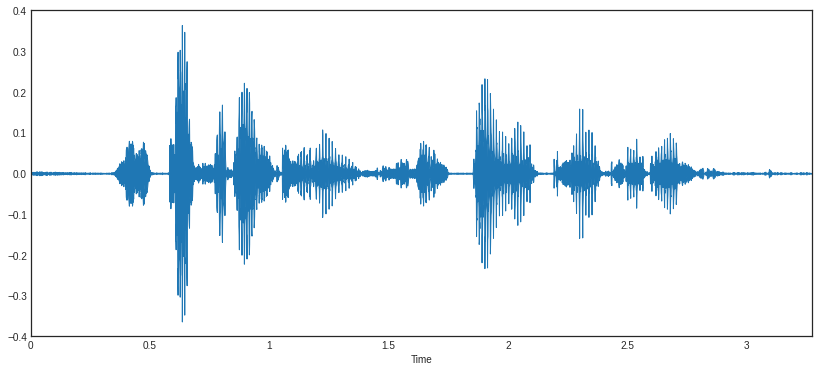

In [20]:
audio_np = audio_data.numpy()

fig = plt.figure(figsize=(14,6))
librosa.display.waveplot(audio_np[0:100000], sr=sr);
#시간에따른 웨이브(파동) 그래프

## 2.정현파(Sinusoid)-Time-Frequency Representation
모든 신호는 주파수(Frequency)와 크기(magnitude), 위상(phase)이 다른 정현파(sinuslida signal)의 조합으로 나타낼 수 있음  
퓨리에 변환은 조합된 정현파의 합(하모니) 신호에서 그 신호를 구성하는 정현파들을 각각 분리해내는 방법

In [ ]:
https://www.youtube.com/watch?v=oltGIc4uo5c&list=PL7ZVZgsnLwEGskuPmm2-pYsNKY8Ihs5AP
36:49